In [39]:
import os
import json
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import zipfile
import urllib.request
from PIL import Image
import random
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
zip_path = "./TestDataSet.zip"
extract_path = "./data"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")

Dataset extracted.


In [4]:
# Load class label mapping
labels_json_path = os.path.join(extract_path, "labels_list.json")
with open(labels_json_path) as f:
    raw_labels = json.load(f)

print(f"Loaded {len(raw_labels)} labels.")
print(raw_labels[:5])

Loaded 100 labels.
['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']


In [5]:
index_file = "imagenet_class_index.json"
if not os.path.exists(index_file):
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    print("Downloading ImageNet class index...")
    urllib.request.urlretrieve("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", index_file)

with open(index_file) as f:
    class_idx = json.load(f)

# Create mapping from WordNet ID to index
wnid_to_idx = {v[0]: int(k) for k, v in class_idx.items()}

# Build folder_to_idx using folder names
folder_to_idx = {}
for folder in sorted(os.listdir(extract_path)):
    folder_path = os.path.join(extract_path, folder)
    if os.path.isdir(folder_path) and folder in wnid_to_idx:
        folder_to_idx[folder] = wnid_to_idx[folder]

In [6]:
print(folder_to_idx)

{'n02672831': 401, 'n02676566': 402, 'n02687172': 403, 'n02690373': 404, 'n02692877': 405, 'n02699494': 406, 'n02701002': 407, 'n02704792': 408, 'n02708093': 409, 'n02727426': 410, 'n02730930': 411, 'n02747177': 412, 'n02749479': 413, 'n02769748': 414, 'n02776631': 415, 'n02777292': 416, 'n02782093': 417, 'n02783161': 418, 'n02786058': 419, 'n02787622': 420, 'n02788148': 421, 'n02790996': 422, 'n02791124': 423, 'n02791270': 424, 'n02793495': 425, 'n02794156': 426, 'n02795169': 427, 'n02797295': 428, 'n02799071': 429, 'n02802426': 430, 'n02804414': 431, 'n02804610': 432, 'n02807133': 433, 'n02808304': 434, 'n02808440': 435, 'n02814533': 436, 'n02814860': 437, 'n02815834': 438, 'n02817516': 439, 'n02823428': 440, 'n02823750': 441, 'n02825657': 442, 'n02834397': 443, 'n02835271': 444, 'n02837789': 445, 'n02840245': 446, 'n02841315': 447, 'n02843684': 448, 'n02859443': 449, 'n02860847': 450, 'n02865351': 451, 'n02869837': 452, 'n02870880': 453, 'n02871525': 454, 'n02877765': 455, 'n0287971

In [7]:
model = models.resnet34(weights="IMAGENET1K_V1").to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [9]:
dataset_path = extract_path

# Use ImageFolder loader
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [10]:
custom_class_to_imagenet_idx = {dataset.class_to_idx[k]: folder_to_idx[k] for k in dataset.class_to_idx}

In [11]:
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(dataloader):
        images = images.to(device)
        targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

        outputs = model(images)
        _, top5 = outputs.topk(5, dim=1)

        top1_correct += (top5[:, 0] == targets).sum().item()
        top5_correct += sum([targets[i] in top5[i] for i in range(len(targets))])
        total += targets.size(0)

100%|██████████| 16/16 [00:02<00:00,  6.37it/s]


In [12]:
print(f"Top-1 Accuracy: {top1_correct / total * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_correct / total * 100:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


### Task 2: Pixel-wise attacks

In [13]:
def fgsm_attack(image, epsilon, data_grad):
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [14]:
adv_output_dir = "./AdversarialTestSet1"
os.makedirs(adv_output_dir, exist_ok=True)

In [15]:
model.eval()
epsilon = 0.02
top1_adv, top5_adv, total_adv = 0, 0, 0
adv_images = []
original_images = []

In [16]:
# Use unnormalized images for saving/visualizing
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean_norms, std_norms)],
    std=[1/s for s in std_norms]
)

In [17]:
for i, (images, targets) in enumerate(tqdm(dataloader)):
    images, targets = images.to(device), targets.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = torch.nn.functional.cross_entropy(outputs, torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device))
    model.zero_grad()
    loss.backward()

    data_grad = images.grad.data
    perturbed_data = fgsm_attack(images, epsilon, data_grad)

    # Save adversarial images for inspection
    for j in range(images.size(0)):
        inv_img = inv_normalize(perturbed_data[j].cpu()).detach().numpy()
        inv_img = np.transpose(inv_img, (1, 2, 0))
        inv_img = np.clip(inv_img * 255, 0, 255).astype(np.uint8)
        img_pil = Image.fromarray(inv_img)
        label_folder = list(dataset.class_to_idx.keys())[targets[j].item()]
        fname = dataset.imgs[i * dataloader.batch_size + j][0].split("/")[-1]
        save_dir = os.path.join(adv_output_dir, label_folder)
        os.makedirs(save_dir, exist_ok=True)
        img_pil.save(os.path.join(save_dir, fname))

    # Evaluate adversarial
    outputs_adv = model(perturbed_data)
    _, top5_preds = outputs_adv.topk(5, dim=1)
    imagenet_targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

    top1_adv += (top5_preds[:, 0] == imagenet_targets).sum().item()
    top5_adv += sum([imagenet_targets[b] in top5_preds[b] for b in range(len(imagenet_targets))])
    total_adv += len(targets)

100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


In [20]:
def show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="FGSM", attack_folder="AdversarialTestSet1"):
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 3 * num_samples))
    fig.suptitle(f"{attack_name} Adversarial Examples", fontsize=16)

    indices = random.sample(range(len(dataset)), num_samples)
    for row, idx in enumerate(indices):
        orig_img_path, class_idx = dataset.imgs[idx]
        folder_name = orig_img_path.split("/")[-2]
        fname = orig_img_path.split("/")[-1]

        # Load and prepare original image
        orig_img = Image.open(orig_img_path).convert('RGB')
        tensor_img = plain_transforms(orig_img).unsqueeze(0).to(device)

        # Prediction on original image
        output = model(tensor_img)
        pred_orig = output.argmax(dim=1).item()

        # Load adversarial image
        adv_path = os.path.join(attack_folder, folder_name, fname)
        adv_img = Image.open(adv_path).convert('RGB')
        tensor_adv = transforms.ToTensor()(adv_img).unsqueeze(0).to(device)
        norm_adv = transforms.Normalize(mean=mean_norms, std=std_norms)(tensor_adv)

        # Prediction on adversarial image
        output_adv = model(norm_adv)
        pred_adv = output_adv.argmax(dim=1).item()

        # Display original
        axs[row, 0].imshow(orig_img)
        axs[row, 0].axis('off')
        axs[row, 0].set_title(f"Original\nTrue: {folder_name}\nPred: {pred_orig}")

        # Display adversarial
        axs[row, 1].imshow(adv_img)
        axs[row, 1].axis('off')
        axs[row, 1].set_title(f"Adversarial\nTrue: {folder_name}\nPred: {pred_adv}")

        # Difference image
        diff = np.abs(np.array(orig_img).astype(np.int16) - np.array(adv_img).astype(np.int16)).astype(np.uint8)
        axs[row, 2].imshow(diff)
        axs[row, 2].axis('off')
        axs[row, 2].set_title("Pixel Difference")

    plt.tight_layout()
    plt.show()

In [21]:
print("\n--- FGSM Attack Results ---")
print(f"Top-1 Accuracy after attack: {top1_adv / total_adv * 100:.2f}%")
print(f"Top-5 Accuracy after attack: {top5_adv / total_adv * 100:.2f}%")


--- FGSM Attack Results ---
Top-1 Accuracy after attack: 26.40%
Top-5 Accuracy after attack: 50.60%


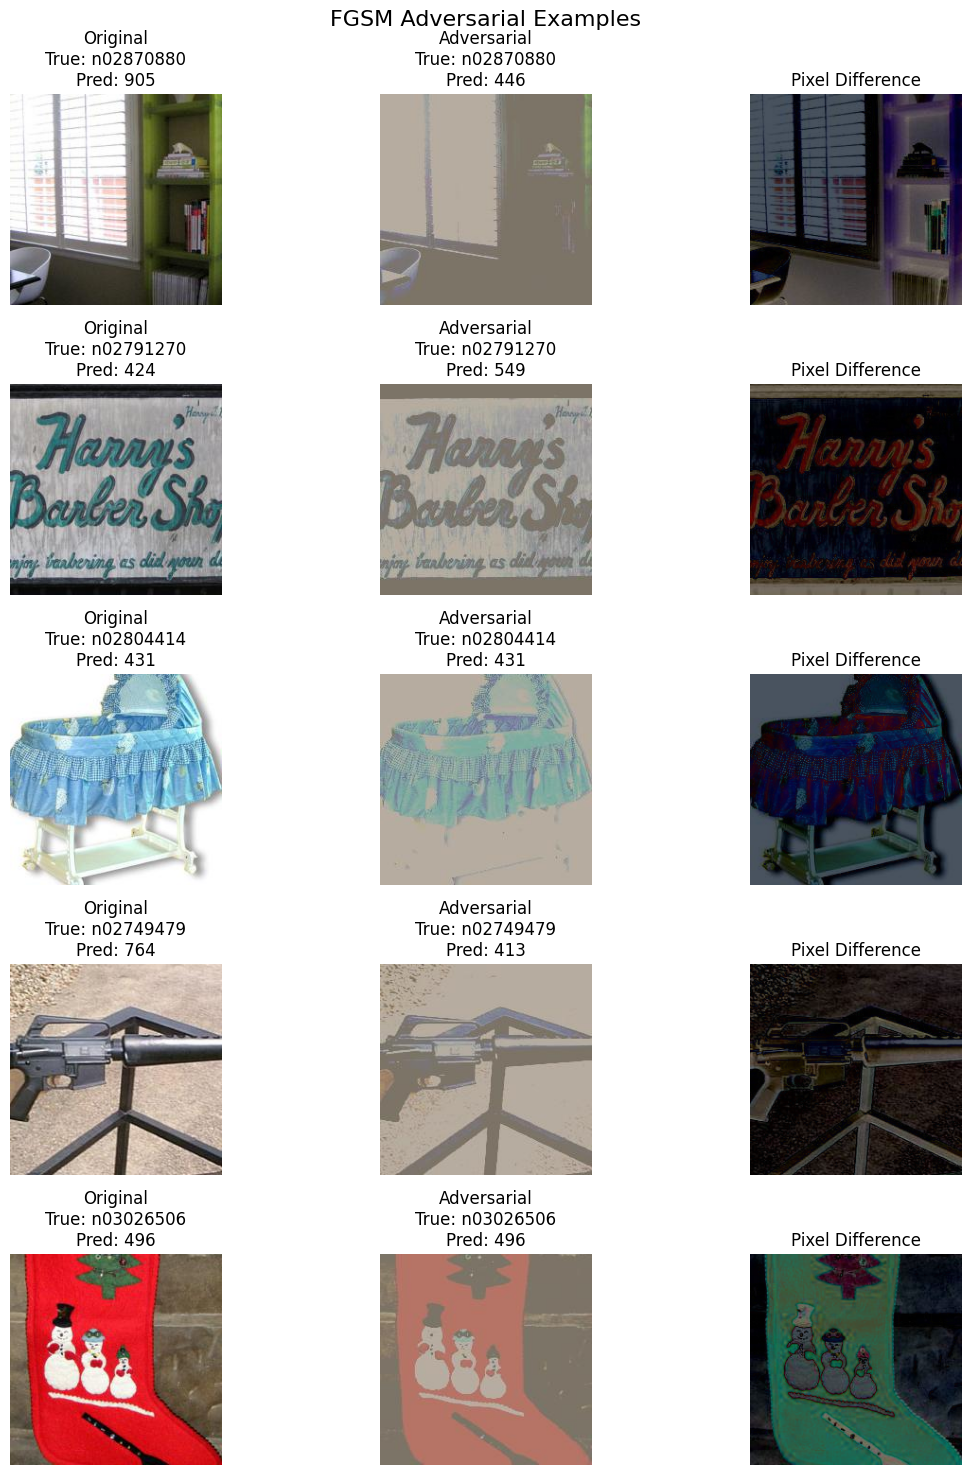

In [22]:
show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="FGSM", attack_folder="AdversarialTestSet1")

### Task 3: Improved Attacks

In [48]:
def pgd_attack(model, images, labels, epsilon, alpha, iters):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
    return images

In [49]:
adv_output_dir_pgd = "./AdversarialTestSet2"
os.makedirs(adv_output_dir_pgd, exist_ok=True)

In [50]:
top1_pgd, top5_pgd, total_pgd = 0, 0, 0

epsilon = 0.02
alpha = 0.005
iters = 10

In [51]:
for i, (images, targets) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    imagenet_targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

    adv_images = pgd_attack(model, images, imagenet_targets, epsilon, alpha, iters)

    # Save adversarial images
    for j in range(images.size(0)):
        inv_img = inv_normalize(adv_images[j].cpu()).detach().numpy()
        inv_img = np.transpose(inv_img, (1, 2, 0))
        inv_img = np.clip(inv_img * 255, 0, 255).astype(np.uint8)
        img_pil = Image.fromarray(inv_img)
        label_folder = list(dataset.class_to_idx.keys())[targets[j].item()]
        fname = dataset.imgs[i * dataloader.batch_size + j][0].split("/")[-1]
        save_dir = os.path.join(adv_output_dir_pgd, label_folder)
        os.makedirs(save_dir, exist_ok=True)
        img_pil.save(os.path.join(save_dir, fname))

    # Evaluate
    outputs_adv = model(adv_images)
    _, top5_preds = outputs_adv.topk(5, dim=1)

    top1_pgd += (top5_preds[:, 0] == imagenet_targets).sum().item()
    top5_pgd += sum([imagenet_targets[b] in top5_preds[b] for b in range(len(imagenet_targets))])
    total_pgd += len(targets)

100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


In [52]:
print("\n--- PGD Attack Results ---")
print(f"Top-1 Accuracy after PGD attack: {top1_pgd / total_pgd * 100:.2f}%")
print(f"Top-5 Accuracy after PGD attack: {top5_pgd / total_pgd * 100:.2f}%")


--- PGD Attack Results ---
Top-1 Accuracy after PGD attack: 2.60%
Top-5 Accuracy after PGD attack: 10.20%


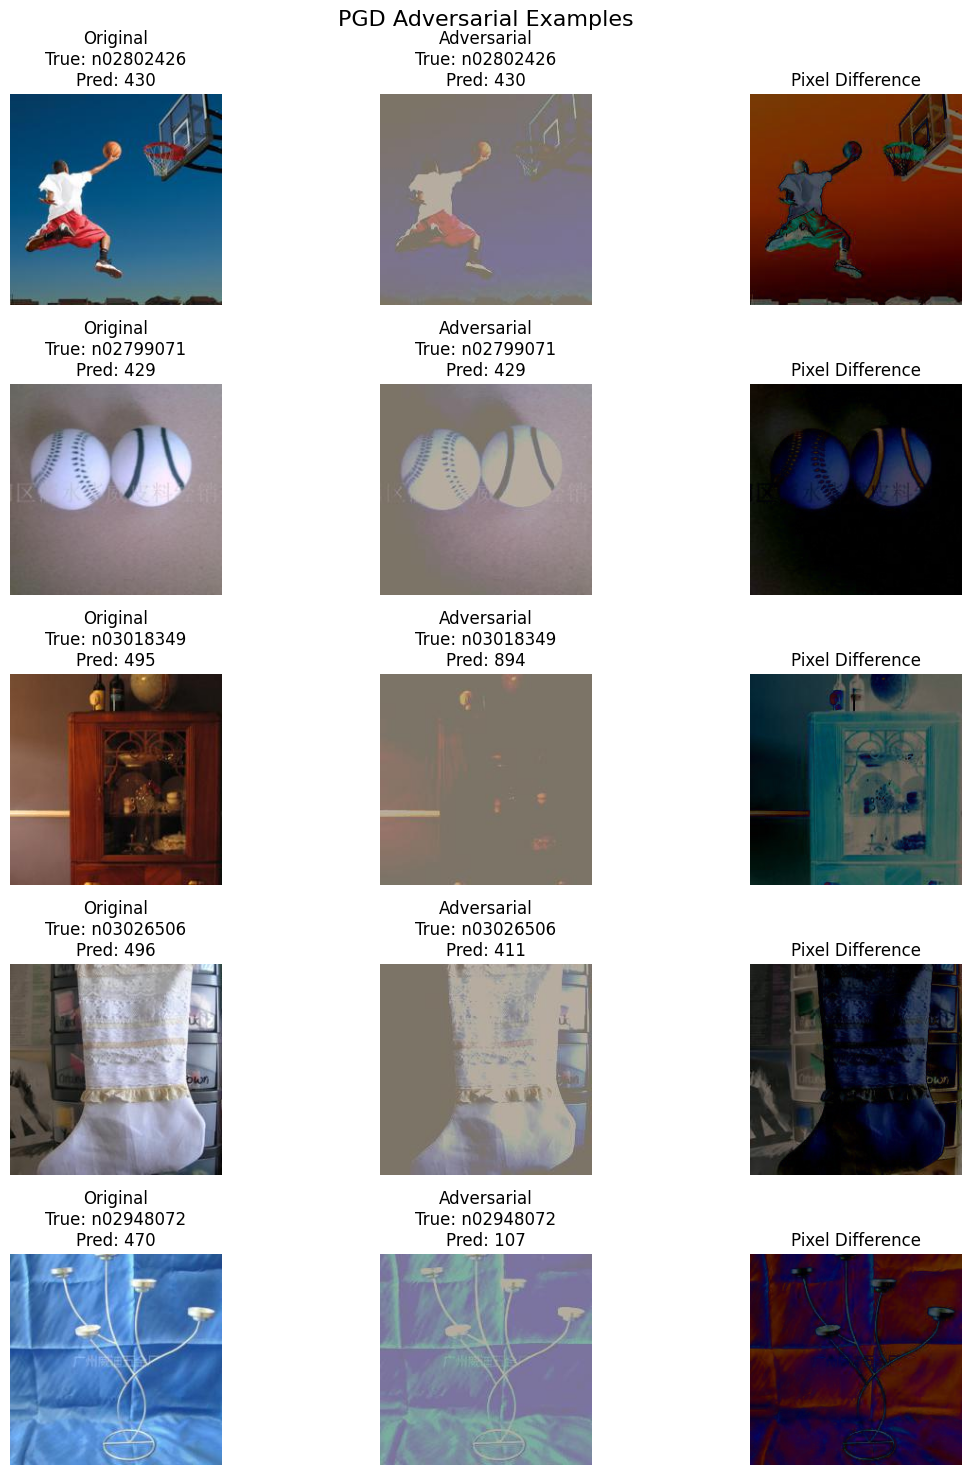

In [53]:
show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="PGD", attack_folder="AdversarialTestSet2")

### Task 4 : Targeted Patch Attack

In [29]:
def targeted_patch_attack(model, images, true_labels, target_labels, epsilon, alpha, iters, patch_size):
    images = images.clone().detach().to(device)
    ori_images = images.clone().detach()
    target_labels = target_labels.to(device)

    b, c, h, w = images.shape
    px, py = patch_size

    # Random patch location
    x_start = np.random.randint(0, w - px)
    y_start = np.random.randint(0, h - py)

    mask = torch.zeros_like(images)
    mask[:, :, y_start:y_start+py, x_start:x_start+px] = 1.0

    for _ in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, target_labels)
        model.zero_grad()
        loss.backward()

        grad = images.grad.data
        adv_images = images - alpha * grad.sign()  # gradient descent to make model predict the target
        adv_images = torch.where(mask.bool(), adv_images, ori_images)
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
    return images

In [30]:
adv_output_dir_patch = "./AdversarialTestSet3"
os.makedirs(adv_output_dir_patch, exist_ok=True)

In [31]:
top1_patch, top5_patch, total_patch = 0, 0, 0

patch_size = (32, 32)
epsilon = 0.3
alpha = 0.01
iters = 20

In [32]:
for i, (images, targets) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    true_labels = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

    # Generate a random target label different from the true label
    target_labels = (true_labels + torch.randint(1, 1000, true_labels.shape).to(device)) % 1000

    adv_images = targeted_patch_attack(model, images, true_labels, target_labels, epsilon, alpha, iters, patch_size)

    # Save adversarial images
    for j in range(images.size(0)):
        inv_img = inv_normalize(adv_images[j].cpu()).detach().numpy()
        inv_img = np.transpose(inv_img, (1, 2, 0))
        inv_img = np.clip(inv_img * 255, 0, 255).astype(np.uint8)
        img_pil = Image.fromarray(inv_img)
        label_folder = list(dataset.class_to_idx.keys())[targets[j].item()]
        fname = dataset.imgs[i * dataloader.batch_size + j][0].split("/")[-1]
        save_dir = os.path.join(adv_output_dir_patch, label_folder)
        os.makedirs(save_dir, exist_ok=True)
        img_pil.save(os.path.join(save_dir, fname))

    # Evaluate
    outputs_adv = model(adv_images)
    _, top5_preds = outputs_adv.topk(5, dim=1)

    top1_patch += (top5_preds[:, 0] == true_labels).sum().item()
    top5_patch += sum([true_labels[b] in top5_preds[b] for b in range(len(true_labels))])
    total_patch += len(targets)

100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


In [33]:
print("\n--- Targeted Patch Attack Results ---")
print(f"Top-1 Accuracy after patch attack: {top1_patch / total_patch * 100:.2f}%")
print(f"Top-5 Accuracy after patch attack: {top5_patch / total_patch * 100:.2f}%")


--- Targeted Patch Attack Results ---
Top-1 Accuracy after patch attack: 35.60%
Top-5 Accuracy after patch attack: 59.20%


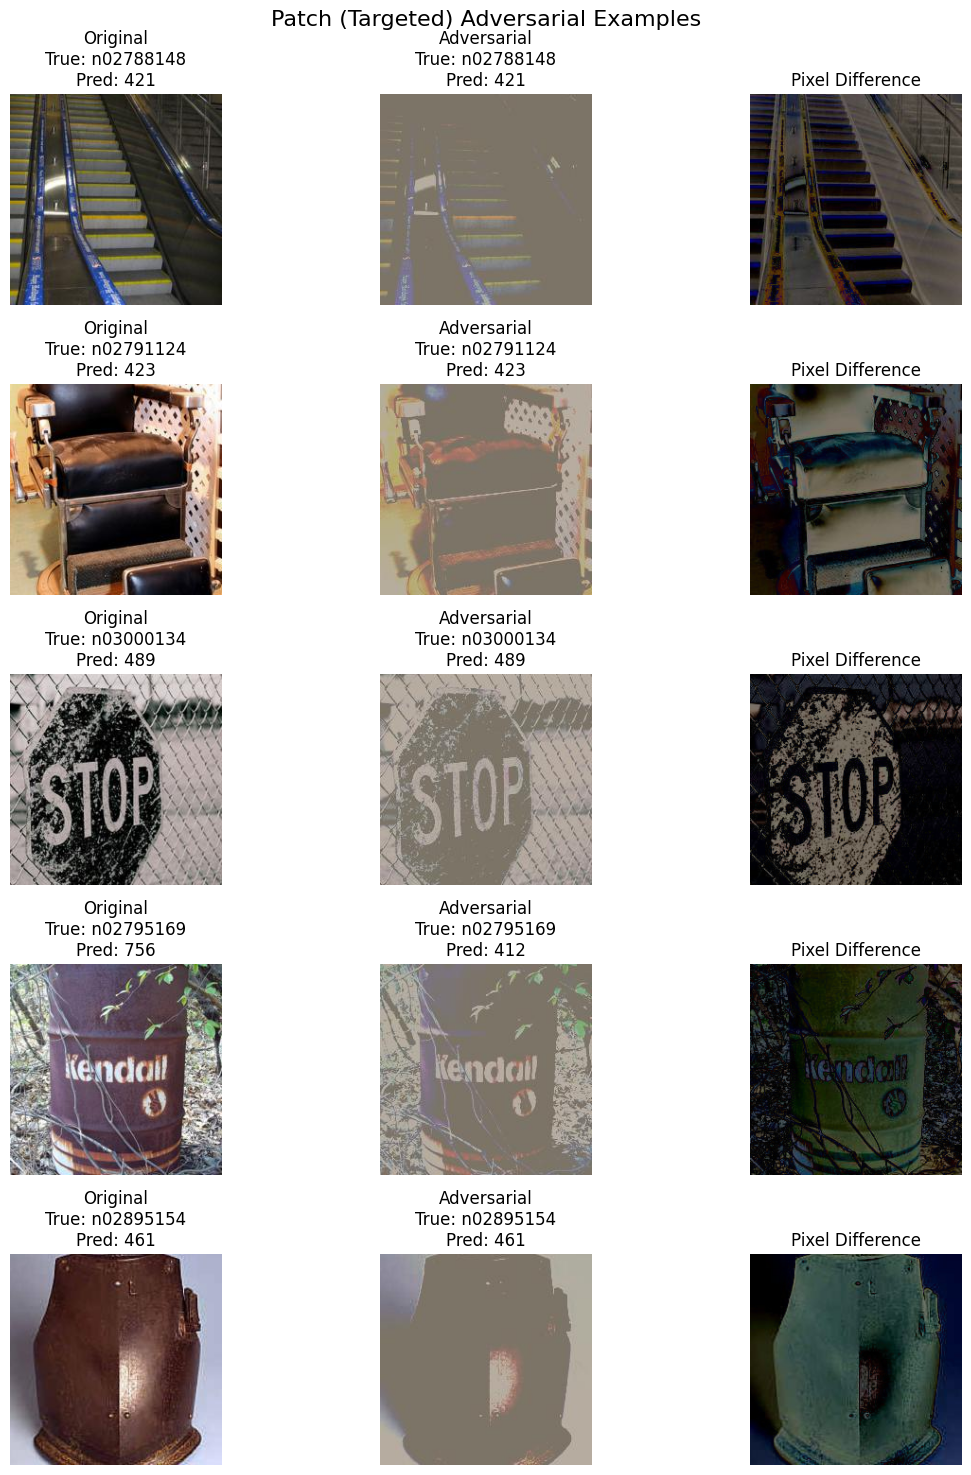

In [34]:
show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="Patch (Targeted)", attack_folder="AdversarialTestSet3")

### Task 5: Transferring Attacks

In [41]:
model_dict = {
    "DenseNet-121": models.densenet121(weights="IMAGENET1K_V1"),
    "MobileNetV3": models.mobilenet_v3_large(weights="IMAGENET1K_V1"),
    "EfficientNet-B0": models.efficientnet_b0(weights="IMAGENET1K_V1")
}

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 140MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


In [42]:
for model_name in model_dict:
    model_dict[model_name] = model_dict[model_name].to(device)
    model_dict[model_name].eval()

In [36]:
def evaluate_on_folder(model, folder_path):
    transfer_dataset = datasets.ImageFolder(root=folder_path, transform=plain_transforms)
    loader = DataLoader(transfer_dataset, batch_size=32, shuffle=False)

    top1, top5, total = 0, 0, 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            top1 += (top5_preds[:, 0] == targets).sum().item()
            top5 += sum([targets[i] in top5_preds[i] for i in range(len(targets))])
            total += len(targets)

    return top1 / total * 100, top5 / total * 100

In [43]:
all_results = {}

In [46]:
for model_name, model in model_dict.items():
    print(f"\n{model_name} Results:")
    results = {}
    baseline_top1, baseline_top5 = None, None

    for name, path in zip([
        "Original",
        "FGSM",
        "PGD",
        "Patch (Targeted)"
    ], [
        dataset_path,
        "AdversarialTestSet1",
        "AdversarialTestSet2",
        "AdversarialTestSet3"
    ]):
        top1, top5 = evaluate_on_folder(model, path)

        if name == "Original":
            baseline_top1, baseline_top5 = top1, top5
            results[name] = (f"{top1:.2f}%", f"{top5:.2f}%")
        else:
            drop1 = (baseline_top1 - top1) / baseline_top1 * 100
            drop5 = (baseline_top5 - top5) / baseline_top5 * 100
            results[name] = (
                f"{top1:.2f}% ({drop1:.1f}%)",
                f"{top5:.2f}% ({drop5:.1f}%)"
            )

        print(f"{name} Dataset → Top-1: {results[name][0]} | Top-5: {results[name][1]}")

    df = pd.DataFrame(results, index=["Top-1 Accuracy", "Top-5 Accuracy"]).T
    all_results[model_name] = df


DenseNet-121 Results:
Original Dataset → Top-1: 74.80% | Top-5: 93.60%
FGSM Dataset → Top-1: 38.60% (48.4%) | Top-5: 59.40% (36.5%)
PGD Dataset → Top-1: 36.40% (51.3%) | Top-5: 59.60% (36.3%)
Patch (Targeted) Dataset → Top-1: 39.60% (47.1%) | Top-5: 61.60% (34.2%)

MobileNetV3 Results:
Original Dataset → Top-1: 83.80% | Top-5: 97.00%
FGSM Dataset → Top-1: 40.40% (51.8%) | Top-5: 66.80% (31.1%)
PGD Dataset → Top-1: 40.80% (51.3%) | Top-5: 67.40% (30.5%)
Patch (Targeted) Dataset → Top-1: 40.80% (51.3%) | Top-5: 69.00% (28.9%)

EfficientNet-B0 Results:
Original Dataset → Top-1: 83.00% | Top-5: 96.80%
FGSM Dataset → Top-1: 41.20% (50.4%) | Top-5: 64.60% (33.3%)
PGD Dataset → Top-1: 40.80% (50.8%) | Top-5: 63.20% (34.7%)
Patch (Targeted) Dataset → Top-1: 44.00% (47.0%) | Top-5: 66.60% (31.2%)


In [47]:
for model_name, df in all_results.items():
    print(f"\nTransferability Summary for {model_name}:")
    print(df)


Transferability Summary for DenseNet-121:
                  Top-1 Accuracy  Top-5 Accuracy
Original                  74.80%          93.60%
FGSM              38.60% (48.4%)  59.40% (36.5%)
PGD               36.40% (51.3%)  59.60% (36.3%)
Patch (Targeted)  39.60% (47.1%)  61.60% (34.2%)

Transferability Summary for MobileNetV3:
                  Top-1 Accuracy  Top-5 Accuracy
Original                  83.80%          97.00%
FGSM              40.40% (51.8%)  66.80% (31.1%)
PGD               40.80% (51.3%)  67.40% (30.5%)
Patch (Targeted)  40.80% (51.3%)  69.00% (28.9%)

Transferability Summary for EfficientNet-B0:
                  Top-1 Accuracy  Top-5 Accuracy
Original                  83.00%          96.80%
FGSM              41.20% (50.4%)  64.60% (33.3%)
PGD               40.80% (50.8%)  63.20% (34.7%)
Patch (Targeted)  44.00% (47.0%)  66.60% (31.2%)


### Transferability Analysis and Discussion

Our evaluation shows that adversarial examples generated using FGSM, PGD, and targeted patch attacks on ResNet-34 substantially reduce classification accuracy across other architectures like DenseNet-121, MobileNetV3, and EfficientNet-B0. Notably:

- **PGD and FGSM** attacks caused Top-1 accuracy to drop by over 40% on average across all networks.
- **Targeted patch attacks**, despite modifying only a small region (32×32), transferred surprisingly well, often with similar or even higher impact than full-image attacks.
- **MobileNetV3 and EfficientNet-B0** seem slightly more robust than DenseNet-121 in Top-5 scores, though all models exhibited vulnerability.

#### Lessons Learned:
- Adversarial attacks **transfer well across architectures**, even when the target model differs significantly in depth, connectivity, or optimization.
- **Small, localized perturbations** (like patch attacks) can still generalize, highlighting that robustness isn't guaranteed by architectural diversity alone.

#### Potential Mitigations:
- **Adversarial training** using diverse attack types can improve robustness against transfer attacks.
- **Input transformations**, like JPEG compression or random resizing, may reduce transfer success by breaking exact gradients.
- **Ensemble defenses** that combine predictions from multiple models can help neutralize specific attack directions.

These findings reinforce the need for evaluating models not just on clean accuracy, but also on their resilience to both white-box and transfer attacks.
